In [ ]:
########################################################################################################################
# Filename: tfidf_Dimension_Reduction.ipynb
#
# Purpose: Generate both liner and nonlinear, low dimensional representations of sparse tf-idf vectors.

# Author(s): Bobby (Robert) Lumpkin, Archit Datar (PCA)
#
# Library Dependencies: numpy, pandas, scikit-learn
########################################################################################################################

# Dimension Reduction for Text Classification 

In [2]:
from sklearn.decomposition import PCA, IncrementalPCA
import numpy as np 
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import json
from joblib import dump, load
import tensorflow as tf
from tensorflow.keras.models import Model

## Linear Representations (Principal Components Analysis)

There are multiple approaches we could take towards determining the number of and which principal components to retain. We'll start by restricting consideration to the first PCs to cumulatively explain $80\%$ of the variance. Then, among these PCs, we'll look for those that most lend themselves towards separating labels by considering the maximum (over labels) of the differences in mean scores between instances having a label and instances not. Then, we'll reduce our dataset to these selected PCs and save for future use.

In [3]:
## Load the data
npzfile = np.load("Data/tfidf_trainTest_data.npz")
X_tfidfTrain = npzfile['X_tfidfTrain']
X_tfidfTest = npzfile['X_tfidfTest']
Y_tfidfTrain = npzfile['Y_tfidfTrain']
Y_tfidfTest = npzfile['Y_tfidfTest']
feature_names = npzfile['feature_names']

file_object = open('Data/label_list.json',)
label_list = json.load(file_object)

In [4]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Fit a PCA object to the training data & save the array of scores 
##                                               for the full set of PCs and the PCA object

pca = PCA(n_components = min(X_tfidfTrain.shape[0], X_tfidfTrain.shape[1]))
X_pcaTrain = pca.fit_transform(X_tfidfTrain)    ## This may take some time to run
#outfile = "Data/PC_scores_full"
#np.savez_compressed(outfile, X_pcaTrain = X_pcaTrain)

# Save the PCA fit
#dump(pca, 'PCA_Model/PCA_fit.joblib', compress = 3) 
#dump(pca, 'PCA_Model/PCA_fit.pkl.lzma', compress = 9)    ## save a compressed version

['Models/PCA_fit.joblib']

In [4]:
## If files exist, load pre-fit and transformed PCA object and scores
pca = load("PCA_Model/PCA_fit.joblib")
npzfile = np.load("Data/tfidf_PC_scores_full.npz")
X_pcaTrain = npzfile['X_pcaTrain']

Target cumulative variance:  0.80
Number of principal components: 2647


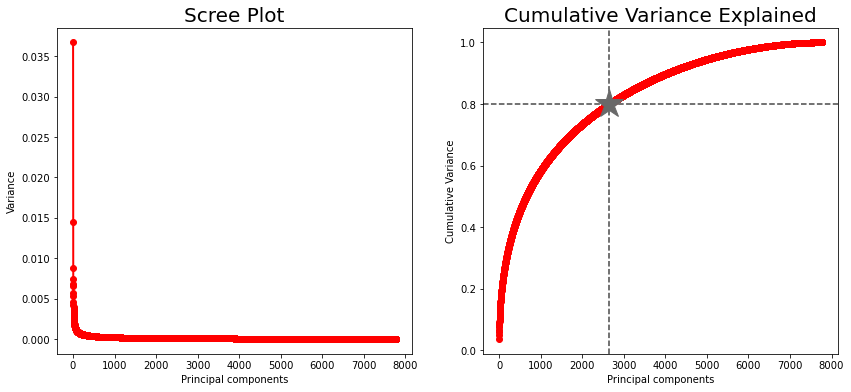

In [9]:
## Generate scree & cumulative variance plots and save the fit PCA object as a .joblib doc
PC_id = np.arange(pca.n_components_) + 1

# Scree plot .
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax1.plot(PC_id, pca.explained_variance_ratio_, 'ro-', linewidth=2)
ax1.set_xlabel("Principal components")
ax1.set_ylabel("Variance")
ax1.set_title("Scree Plot", size = 20)

# Cumulative variance plot
cum_var = np.cumsum(pca.explained_variance_ratio_) #cumulative variance.
target_cum_var = 0.8    # Target cumulative variance.
PCs_retained = np.where(cum_var>target_cum_var)[0][0] + 1    # Number of principal components retained to explain target

ax2 = fig.add_subplot(122)
ax2.plot(PC_id, cum_var, 'ro-', linewidth=2)
ax2.set_xlabel("Principal components")
ax2.set_ylabel("Cumulative Variance")
ax2.set_xlim()
ax2.set_ylim()
ax2.hlines(target_cum_var, ax2.get_xlim()[0], ax2.get_xlim()[1], linestyles = "--", colors = plt.cm.Greys(200))
ax2.vlines(PCs_retained, ax2.get_ylim()[0], ax2.get_ylim()[1], linestyles = "--", colors = plt.cm.Greys(200))
ax2.plot(PCs_retained, target_cum_var, color = 'dimgrey', marker = '*', markersize = 30)
ax2.set_title("Cumulative Variance Explained", size = 20)

print(f"Target cumulative variance: {target_cum_var: .2f}")
print(f"Number of principal components: {PCs_retained}")

PC_list = [f"PC-{comp}" for comp in np.arange(1, PCs_retained+1)]
PC_scores_cumVar = X_pcaTrain[:, 0 : PCs_retained]

In [10]:
## Create dataframes with PC scores and labels for training and test data
df_train_features = pd.DataFrame(PC_scores_cumVar, columns = PC_list)
df_train_labels = pd.DataFrame(Y_tfidfTrain, columns = label_list)
df_test_features = pd.DataFrame(pca.transform(X_tfidfTest)[:, 0 : PCs_retained], columns = PC_list)
df_test_labels = pd.DataFrame(Y_tfidfTest, columns = label_list)

Number of principal components with max absolute difference (between 1 and 0 label means) above cutoff 0.1 : 33


Text(0, 0.5, 'Frequency')

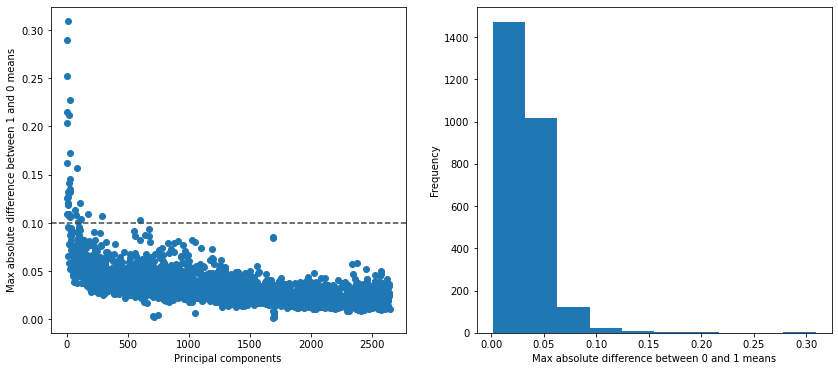

In [13]:
## For each label, check the absolute differences in the means for scores corresponding to 1-instances and scores 
## corresponding to 0-instances. Retain only PCs that sufficiently allow for separation of labels

# New dataframe storing the rows as the principal components and columns as the labels with values 
# indicating the difference between the positive and negative means.
df_diff = pd.DataFrame(index = PC_list, columns = label_list)
for label in label_list:
    df_diff[label] = df_train_features.loc[df_train_labels[label] == 1, PC_list].mean(axis = 0).values - \
                                df_train_features.loc[df_train_labels[label] == 0, PC_list].mean(axis = 0).values
df_diff["mod_max_diff"] = np.abs(df_diff[label_list]).max(axis = 1)

target_difference_cutoff = 0.1 
num_sepPCs = df_diff[df_diff['mod_max_diff'] >= target_difference_cutoff].shape[0]
print("Number of principal components with max absolute difference (between 1 and 0 label means) above cutoff " + 
      f"{target_difference_cutoff} : {num_sepPCs}")

separable_PC_list = df_diff.loc[df_diff['mod_max_diff'] >= target_difference_cutoff].index.values

# Plotting the principal components' max absolute differences
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
ax.scatter(np.arange(1, df_diff.shape[0]+1), df_diff["mod_max_diff"])
ax.set_xlabel("Principal components")
ax.set_ylabel("Max absolute difference between 1 and 0 means")
ax.set_xlim()
ax.hlines(target_difference_cutoff, ax.get_xlim()[0], ax.get_xlim()[1], linestyles="--", color=plt.cm.Greys(200))

ax2 = fig.add_subplot(122)
ax2.hist(df_diff["mod_max_diff"])
ax2.set_xlabel("Max absolute difference between 0 and 1 means")
ax2.set_ylabel("Frequency")

In [12]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Define and save the separable PC scores for the training and test data
X_sepPCs_train = df_train_features[separable_PC_list].values
Y_train = df_train_labels[label_list].values
X_sepPCs_test = df_test_features[separable_PC_list].values
Y_test = df_test_labels[label_list].values

outfile = "Data/tfidf_PC_separable.npz"
#np.savez_compressed(outfile, X_sepPCs_train = X_sepPCs_train, 
#                             X_sepPCs_test = X_sepPCs_test, 
#                             Y_train = Y_train, 
#                             Y_test = Y_test,
#                             separable_PC_list = separable_PC_list)


## Nonlinear Representations (ANN Autoencoder)

In [33]:
latent_dim = num_sepPCs
visible_dim = feature_names.shape[0]

class Autoencoder(Model):
    def __init__(self, latent_dim, visible_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(latent_dim * 2, activation = 'tanh'),
            tf.keras.layers.Dense(latent_dim, activation = 'relu'),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(latent_dim * 2, activation = 'sigmoid'),
            tf.keras.layers.Dense(visible_dim, activation = 'relu'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim, visible_dim)

In [34]:
autoencoder.compile(optimizer = 'adam', loss = tf.keras.losses.MeanSquaredError())

In [35]:
tf.random.set_seed(123)
autoencoder.fit(X_tfidfTrain, X_tfidfTrain,
                epochs = 10,
                shuffle = True,
                validation_data = (X_tfidfTest, X_tfidfTest))

Epoch 1/10
243/243 [==============================] - 20s 77ms/step - loss: 3.5516e-05 - val_loss: 1.9507e-05
Epoch 2/10
243/243 [==============================] - 11s 47ms/step - loss: 1.9504e-05 - val_loss: 1.9523e-05
Epoch 3/10
243/243 [==============================] - 11s 46ms/step - loss: 1.9521e-05 - val_loss: 1.9536e-05
Epoch 4/10
243/243 [==============================] - 12s 50ms/step - loss: 1.9525e-05 - val_loss: 1.9534e-05
Epoch 5/10
243/243 [==============================] - 13s 53ms/step - loss: 1.9531e-05 - val_loss: 1.9547e-05
Epoch 6/10
243/243 [==============================] - 12s 48ms/step - loss: 1.9536e-05 - val_loss: 1.9536e-05
Epoch 7/10
243/243 [==============================] - 12s 47ms/step - loss: 1.9535e-05 - val_loss: 1.9537e-05
Epoch 8/10
243/243 [==============================] - 11s 46ms/step - loss: 1.9537e-05 - val_loss: 1.9533e-05
Epoch 9/10
243/243 [==============================] - 11s 46ms/step - loss: 1.9534e-05 - val_loss: 1.9534e-05
Epoch 10/1

In [67]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Get and save encodings for the training/test data 
encoded_train = autoencoder.encoder(X_tfidfTrain).numpy()
encoded_test = autoencoder.encoder(X_tfidfTest).numpy()

outfile = "Data/tfidf_encoded_data.npz"
#np.savez_compressed(outfile, encoded_train = encoded_train,
#                    encoded_test = encoded_test,
#                    Y_train = Y_tfidfTrain,
#                    Y_test = Y_tfidfTest)